# Hourly and Diel patterns in fluxes

In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline
sns.set_style("white")

/home/greg/data/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = 'figures/multiyear_figs/'

# Years to load
start = 2007
end = 2015
# Sites to load
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']

# Since we are calculating some time of day stats we need hourly data
# Fill a dict with multiyear hourly dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

# Also open local daily files (we will add to them)
daily_path = '/home/greg/current/NMEG_utils/processed_data/daily_aflx/'
daily = { x : 
         ld.load_local_file( daily_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }


Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2015_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Make some hourly calculations (C uptake, evaporative fraction)

In [3]:
for site in sites:
    # Add a column with 0.5 for each uptake period (to sum)
    hourly[site]['hrs_C_uptake'] = 0
    test = hourly[site].FC_F < 0
    hourly[site].loc[test, 'hrs_C_uptake'] = 0.5
    
    hourly[site]['evap_frac'] = np.nan
    bowen =  hourly[site].H_F / hourly[site].LE_F
    hourly[site].evap_frac = 1/(1+bowen)
    day_test = hourly[site].SW_IN_F < 50
    hourly[site].loc[day_test, 'evap_frac'] = np.nan
    
# Beware here that the bowen ratio looks a little crazy, especially at night.
# Perhaps we need to do a better job of removing/correcting H and LE fluxes

### Append hourly calculations to daily data

In [4]:

# Get time of min NEE, max GPP, and daily ET and PET
for i, site in enumerate(sites):
    h = hourly[site]
    # Get the time of day for peak GPP each day
    gpp_grp = h.GPP.groupby(h.index.date)
    peakGPP_t = gpp_grp.apply(lambda x: x.index[x==x.max()].time)
    # Get the time of day for peak NEE each day
    nee_grp = h.FC_F.groupby(h.index.date)
    peakNEE_t = nee_grp.apply(lambda x: x.index[x==x.min()].time)
    # Get the time of day for peak RECO each day
    reco_grp = h.RECO.groupby(h.index.date)
    peakRECO_t = reco_grp.apply(lambda x: x.index[x==x.min()].time)
    def get_frac( arr ):
        # Sometimes these are empty
        if len(arr)==0:
            return np.nan
        else:
            return (arr[0].hour*3600 + arr[0].minute*60)/(3600*24)
    #pdb.set_trace()
    daily[site]['hrs_C_uptake_sum'] = h.hrs_C_uptake.resample('1D').sum()
    daily[site]['evap_frac_avg'] = h.evap_frac.resample('1D').mean()
    daily[site][ 'peakGPP_dayfrac'] = peakGPP_t.apply( get_frac )
    daily[site][ 'peakNEE_dayfrac'] = peakNEE_t.apply( get_frac )
    daily[site][ 'peakRECO_dayfrac'] = peakRECO_t.apply( get_frac )
    
# Convert this to a pandas panel
d = pd.Panel(daily)

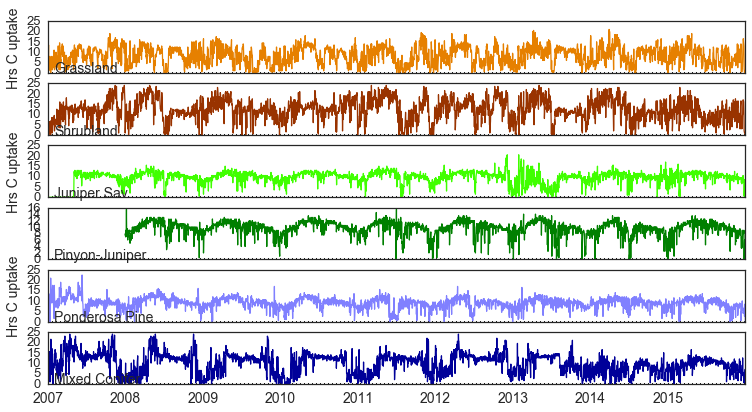

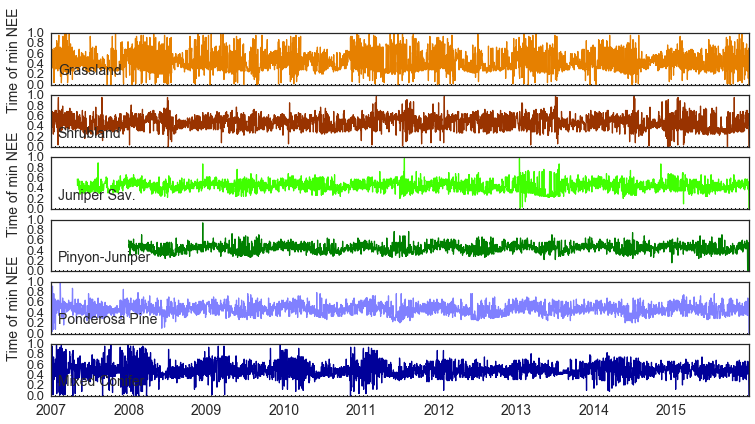

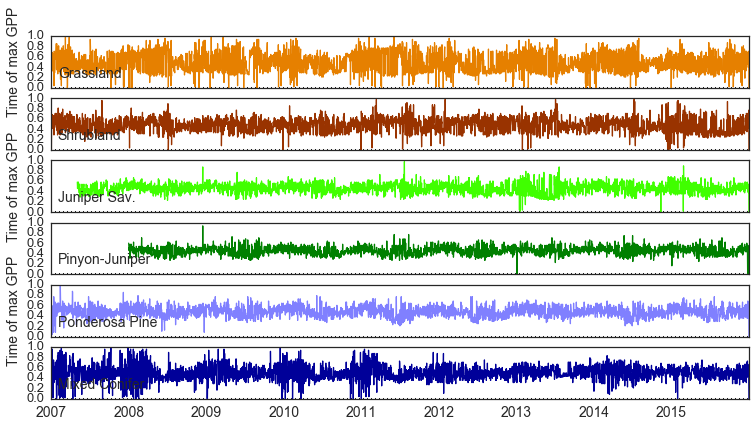

In [5]:
# Plot the hourly calculations to see how they look
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'hrs_C_uptake_sum', .2, fig, 'Hrs C uptake')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakNEE_dayfrac', .2, fig, 'Time of min NEE')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakGPP_dayfrac', .2, fig, 'Time of max GPP')

## Diurnal curves

In [23]:
import math
def get_diel_pattern( ser ):
    df_diel = pd.DataFrame()
    # Group by time of day
    df_diel['mean_24h'] = ser.groupby(ser.index.time).mean()
    df_diel['std_24h'] = ser.groupby(ser.index.time).std()
    df_diel['n_obs']= ser.groupby(ser.index.time).size()
    return df_diel

In [183]:
def plot_diel( sitedict, varname, legstrs=None ):
    ax_out = list()
    for i, site in enumerate( sites ):
        ax = plt.subplot( 3, 2, i+1 )
        df = sitedict[site]
        diel = get_diel_pattern(df[varname])
        ax.plot(diel.index, diel.mean_24h, color=nmegplt.palette[site], label='All')
        ax.plot(diel.index, (diel.mean_24h + diel.std_24h), ':k', label=None)
        ax.plot(diel.index, (diel.mean_24h - diel.std_24h), ':k', label=None)
        plt.xlabel('')
        plt.xlim([0,24*3600])
        ax_out.append(ax)
        
        if i==0 and legstrs: # Currently not needed
            ax.legend(legstrs)
        elif i==2:
            ax.set_ylabel(varname)
        elif i > 3:
            # FIXME - funny stuff goint on with x axis ticks and labels
            ax.set_xlabel('hour of day')
            ax.set_xticks(list(range(0, 25*3600,4*3600)))
            ax.set_xticklabels(list(range(0, 25,4)))
        if i < len(sites)-2:
            plt.setp( ax.get_xticklabels(), visible=False)
    return ax_out

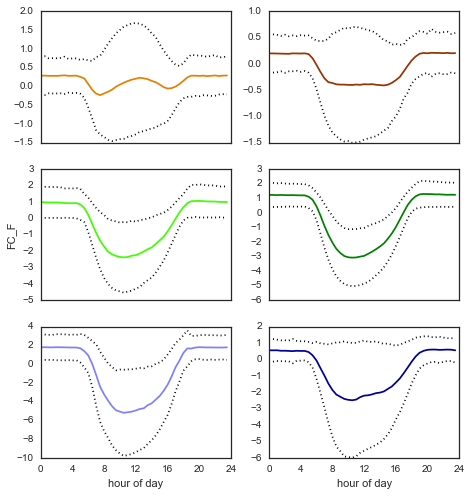

In [174]:
fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
plot_diel(hourly, 'FC_F')
#fig.savefig('../figures/labmeeting/fc_diurnal.svg', dpi=150)

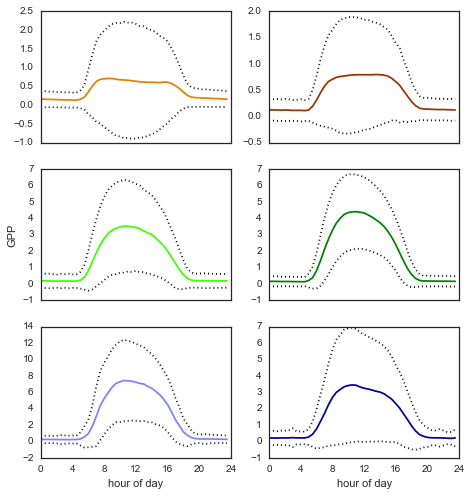

In [175]:
fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
plot_diel(hourly, 'GPP')
#fig.savefig('../figures/labmeeting/gpp_diurnal.svg', dpi=150)

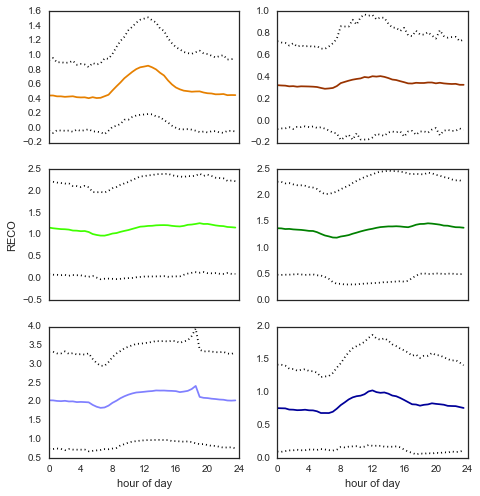

In [176]:
fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
plot_diel(hourly, 'RECO')
#fig.savefig('../figures/labmeeting/reco_diurnal.svg', dpi=150)

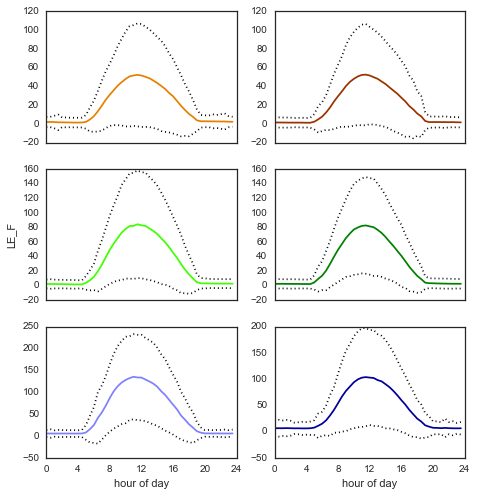

In [177]:
fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
plot_diel(hourly, 'LE_F')
#fig.savefig('../figures/labmeeting/reco_diurnal.svg', dpi=150)

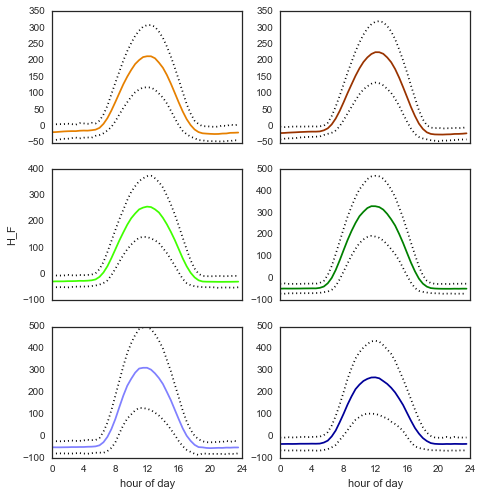

In [178]:
fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
plot_diel(hourly, 'H_F')
#fig.savefig('../figures/labmeeting/reco_diurnal.svg', dpi=150)

## Diel patterns compared (normal and anomaly days)

In [179]:
# Get VPD_max anomaly and dates of high vpd
vpd_anom = {x: tr.var_anomaly(daily[x].VPD_F_max) for x in sites}
highvpd = {x: vpd_anom[x][vpd_anom[x] > 1].index.date for x in sites}

# Subset the hourly dataset to only include high vpd days
highvpd_h = {x: hourly[x].loc[pd.to_datetime(hourly[x].index.date).isin(
            highvpd[x]),:] for x in sites}

# Another way to do the above step
#highvpd_h = dict()
#for i, site in enumerate(sites):
#    match = pd.to_datetime(hourly[site].index.date).isin(highvpd[site])
#    highvpd_h[site] = hourly[site].loc[match,:]

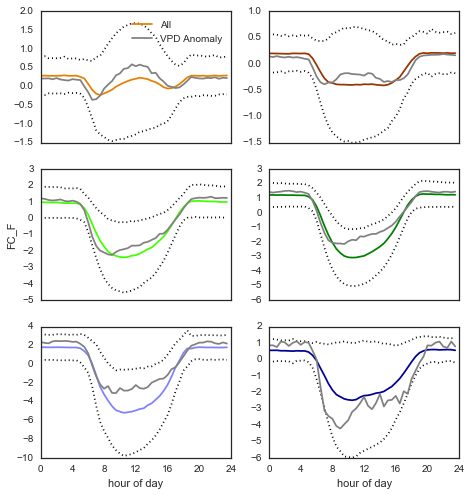

In [180]:
# Get diel pattern for high vpd FC_F
hivpd_dielFC = {x: get_diel_pattern(highvpd_h[x].FC_F) for x in sites}

fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
axes = plot_diel(hourly, 'FC_F')
for i, site in enumerate(sites):
    dat = hivpd_dielFC[site]
    newh, = axes[i].plot(dat.index, dat.mean_24h, color='gray', label='VPD Anomaly')
# Add legend
axes[0].legend()

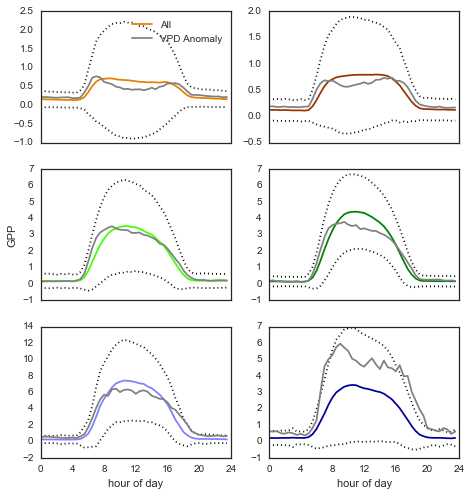

In [181]:
# Get diel pattern for high vpd GPP
hivpd_dielGPP = {x: get_diel_pattern(highvpd_h[x].GPP) for x in sites}

fig = plt.figure(figsize=( 7.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
axes = plot_diel(hourly, 'GPP')
for i, site in enumerate(sites):
    dat = hivpd_dielGPP[site]
    newh, = axes[i].plot(dat.index, dat.mean_24h, color='gray', label='VPD Anomaly')
# Add legend
axes[0].legend()